# R Script for Offline Model Training

Pulls sample data from the natality public data set available on BigQuery, which records data about births in the US from 1969 to 2008, and trains a linear regression model to predict birth weight based on multiple factors. This script performs the following steps:

* Loads packages necessary for pulling data from BigQuery and outputing the trained model to PMML
* Pulls sampled data into an R data frame
* Displays a histogram of birth weights in the sampled data
* Trains a linear regression model to predict birth weights and summarizes the model
* Computes error metrics
* Exports the model to PMML

https://cloud.google.com/bigquery/sample-tables

In [36]:
library(bigrquery) 
library(r2pmml)
project <- "gcp_project_id"  

In [35]:
sql <- "
SELECT year, plurality, apgar_5min, mother_age, father_age, gestation_weeks, ever_born
  ,case when mother_married then 1 else 0 end as mother_married, weight_pounds
FROM `bigquery-public-data.samples.natality`
where year is not null and plurality is not null and apgar_5min is not null 
  and mother_age is not null and father_age is not null and gestation_weeks is not null
  and ever_born is not null and mother_married is not null and weight_pounds is not null
order by rand() 
LIMIT 10000 
"

df <- query_exec(sql, project = project, use_legacy_sql = FALSE) 
str(df)

Auto-refreshing stale OAuth token.
8.1 gigabytes processed


'data.frame':	10000 obs. of  9 variables:
 $ year           : int  1995 1990 1999 1999 1995 1985 1996 1993 1997 1992 ...
 $ plurality      : int  1 1 1 1 2 1 1 1 1 1 ...
 $ apgar_5min     : int  10 9 9 9 9 99 99 99 9 10 ...
 $ mother_age     : int  26 38 23 21 26 20 28 29 22 32 ...
 $ father_age     : int  26 44 24 28 22 22 29 30 28 32 ...
 $ gestation_weeks: int  40 41 40 39 38 40 41 39 39 40 ...
 $ ever_born      : int  3 1 1 1 2 2 1 1 1 6 ...
 $ mother_married : int  1 1 1 0 0 1 1 1 1 1 ...
 $ weight_pounds  : num  7 8.76 6 5.69 8.44 ...


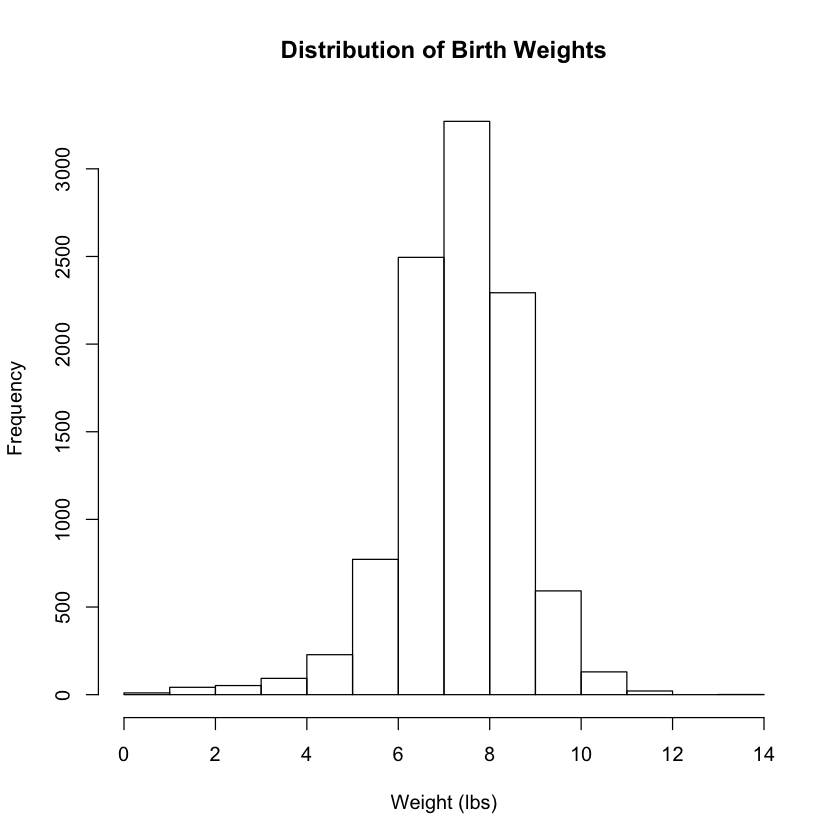

In [40]:
hist(df$weight_pounds, main = "Distribution of Birth Weights", xlab = "Weight (lbs)")

In [41]:
lm <- lm(weight_pounds ~ ., data = df)
summary(lm)


Call:
lm(formula = weight_pounds ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2106 -0.6639  0.0409  0.7672  5.8768 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.3963888  3.1391909   2.993  0.00277 ** 
year            -0.0005156  0.0015702  -0.328  0.74263    
plurality       -2.0680228  0.0722753 -28.613  < 2e-16 ***
apgar_5min       0.0004909  0.0003689   1.331  0.18329    
mother_age       0.0102568  0.0024987   4.105 4.08e-05 ***
father_age      -0.0017567  0.0005992  -2.932  0.00338 ** 
gestation_weeks  0.0154192  0.0014031  10.989  < 2e-16 ***
ever_born        0.0137641  0.0103621   1.328  0.18411    
mother_married   0.3139233  0.0361180   8.692  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.245 on 9991 degrees of freedom
Multiple R-squared:  0.1121,	Adjusted R-squared:  0.1114 
F-statistic: 157.7 on 8 and 9991 DF,  p-value: < 2.2e-16


In [48]:
cat("Correlation Coefficient: ") 
cat(round(cor(df$weight_pounds, predict(lm, df)), 3))

cat("\nMean Error: ") 
cat(round(mean(abs(df$weight_pounds - predict(lm, df))), 3))

cat("\nRMSE: ") 
cat(round(sqrt(mean(abs(df$weight_pounds - predict(lm, df)^2))), 3))


Correlation Coefficient: 0.335
Mean Error: 0.928
RMSE: 6.825

In [49]:
r2pmml(lm, "natality.pmml")